In [537]:
import pandas as pd

In [538]:
import cortex

In [539]:
import glob

In [540]:
import re
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-(.+)_ses-.+_hemi-(?P<hemi>lh|rh)_energies\.pkl')

In [541]:
fns = glob.glob('/data/odc/derivatives/zmap_spatfreq/sub-*/ses-*/func/sub-*_ses-*_hemi-*_energies.pkl')

In [542]:
def get_vertex_mask(subject, hemi='lh', roi='V1'):
    
    
    if hemi == 'lh':
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'l')[roi+hemi[:1]]
    elif hemi == 'rh':
        left_pts, _ = cortex.db.get_surf('odc.{}'.format(subject), hemisphere='left', type='fiducial')
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'r')[roi+hemi[:1]]
        mask -= len(left_pts)
        
    return mask

In [543]:
energies = []
idx = []

for fn in fns:
    e = pd.read_pickle(fn)
    e = e.loc[:,~e.isnull().any(0)]

    meta = reg.match(fn).groupdict()    
    mask = get_vertex_mask(meta['subject'], meta['hemi'])
    
    ix = e.columns.intersection(mask)
    
    e = e.loc[:, ix]    
    print('{}/{} V1 vertices have energy ({}, {})'.format(len(ix), len(mask), meta['subject'], meta['session'], meta['hemi']))
    
    idx.append(meta)
    
    energies.append(e)
    
# energies = pd.concat(energies, axis=0)

3072/6597 V1 vertices have energy (bm, odc)
2179/4628 V1 vertices have energy (bm, odc)
5320/11046 V1 vertices have energy (de, odc1)
3025/9886 V1 vertices have energy (de, odc1)
3553/9503 V1 vertices have energy (eo, odc)
4863/8879 V1 vertices have energy (eo, odc)
3170/7012 V1 vertices have energy (ms, odc2)
2880/6888 V1 vertices have energy (ms, odc2)
5004/9560 V1 vertices have energy (ns, odc)
2736/9847 V1 vertices have energy (ns, odc)
2740/5771 V1 vertices have energy (tk, odc2)
3347/6746 V1 vertices have energy (tk, odc2)
2682/5771 V1 vertices have energy (tk, odc3)
2992/6746 V1 vertices have energy (tk, odc3)
4455/9629 V1 vertices have energy (tr, odc)
5571/10898 V1 vertices have energy (tr, odc)


In [544]:
energies = pd.concat(energies, 
                     keys=[(d['subject'], d['session'], d['hemi']) for d in idx], 
                     names=['subject', 'session', 'hemi', 'vertex'],
                     axis=1)

In [545]:
energies_incl_outliers = energies.copy()

In [546]:
energies = energies.drop([('bm', 'odc', 'lh'), ('ns')], axis=1)

In [547]:
max_frequency = energies.groupby(['depth', 'frequency']).sum().groupby('depth', as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax())

In [548]:
max_wl = 1. / max_frequency

In [549]:
import pymc3 as pm

In [550]:
mode_frequency_per_vertex = energies.groupby(['depth', 'frequency']).sum().groupby(['depth'], as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax(0))
wl = mode_frequency_per_vertex.T.stack('depth').to_frame('main frequency').groupby(['subject', 'session', 'hemi', 'depth']).median()
wl['wavelength'] = 1./wl['main frequency']

In [551]:
wl.loc[(slice(None), slice(None), 'lh', slice(None)), :]

main frequency  wavelength
subject session hemi depth                            
de      odc1    lh   0.143        0.355648    2.811769
                     0.286        0.355648    2.811769
                     0.429        0.355648    2.811769
                     0.571        0.355648    2.811769
                     0.714        0.372759    2.682696
                     0.857        0.372759    2.682696
eo      odc     lh   0.143        0.339322    2.947052
                     0.286        0.323746    3.088844
                     0.429        0.308884    3.237458
                     0.571        0.323746    3.088844
                     0.714        0.308884    3.237458
                     0.857        0.339322    2.947052
ms      odc2    lh   0.143        0.390694    2.559548
                     0.286        0.409492    2.442053
                     0.429        0.429193    2.329952
                     0.571        0.409492    2.442053
                     0.714        0.390694    2.559548
                     0.857        0.372759    2.682696
tk      odc2    lh   0.143        0.409492    2.442053
                     0.286        0.390694    2.559548
                     0.429        0.409492    2.442053
                     0.571        0.372759    2.682696
                     0.714        0.355648    2.811769
                     0.857        0.308884    3.237458
        odc3    lh   0.143        0.390694    2.559548
                     0.286        0.409492    2.442053
                     0.429        0.390694    2.559548
                     0.571        0.409492    2.442053
                     0.714        0.409492    2.442053
                     0.857        0.429193    2.329952
tr      odc     lh   0.143        0.355648    2.811769
                     0.286        0.372759    2.682696
                     0.429        0.372759    2.682696
                     0.571        0.372759    2.682696
                     0.714        0.372759    2.682696
                     0.857        0.390694    2.559548

In [552]:
unique_subjects = power.subject.unique().tolist()
power['Subject'] = power['subject'].map(lambda d: 'Subject {}'.format(unique_subjects.index(d) + 1))
power['Power'] = power['power']

unique_depths = power.depth.unique().tolist()
power['Layer'] = power.depth.map(lambda d: 6 - unique_depths.index(d))

In [553]:
mean_wl_energie_across_orientations = energies.groupby(['depth', 'frequency']).mean()

In [554]:
power = mean_wl_energie_across_orientations.T.groupby(['subject', 'session', 'hemi']).mean().stack(['depth', 'frequency'])
power = power.to_frame('power').reset_index()
power['wavelength'] = 1./power['frequency']

In [555]:
unique_subjects = power.subject.unique().tolist()
power['Subject'] = power['subject'].map(lambda d: 'Subject {}'.format(unique_subjects.index(d) + 1))
power['Power'] = power['power']

unique_depths = power.depth.unique().tolist()
power['Layer'] = power.depth.map(lambda d: 6 - unique_depths.index(d))

In [556]:
def fit_linear_quadratic_model(df, subj_label='subject', x='depth', y='power'):

    n_subj = len(df[subj_label].unique())
    subject_idx = df[subj_label].map(lambda x: df[subj_label].unique().tolist().index(x))
    x = df[x]
    y = df[y]    
    
    with pm.Model() as model1:

            # define priors:
        h_b0 = pm.Normal('h_b0', mu=0, sd=1)
        sigma_h_b0 = pm.HalfCauchy('sigma_h_b0', beta=5.)
        h_b1 = pm.Normal('h_b1', mu=0, sd=1)
        sigma_h_b1 = pm.HalfCauchy('sigma_h_b1', beta=5.)
        
        b0_ = pm.Normal('b0_', mu=0, sd=1, shape=n_subj) # intercept
        b1_ = pm.Normal('b1_', mu=0, sd=1, shape=n_subj) # 1st order coefficient for each subject (slope)
        
        b0 = pm.Deterministic('b0', h_b0 + sigma_h_b0 * b0_[subject_idx])
        b1 = pm.Deterministic('b1', h_b1 + sigma_h_b1 * b1_[subject_idx])

        ## define Linear model
        yest = pm.Deterministic(name='yest', var=b0 + (b1 * x))

        ## define Normal likelihood with HalfNormal noise
        sigma_y = pm.HalfNormal('sigma_y', sd=1)
        likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=y)

        trace1 = pm.sample(2000, tune=1000)
    
    with pm.Model() as model2:

        # define priors:
        h_b0 = pm.Normal('h_b0', mu=0, sd=1)        
        sigma_h_b0 = pm.HalfCauchy('sigma_h_b0', beta=5)
        h_b1 = pm.Normal('h_b1', mu=0, sd=1)
        sigma_h_b1 = pm.HalfCauchy('sigma_h_b1', beta=5)
        h_b2 = pm.Normal('h_b2', mu=0, sd=1)
        sigma_h_b2 = pm.HalfCauchy('sigma_h_b2', beta=5)
#         b0 = pm.Normal('b0', mu=h_b0, sd=sigma_h_b0, shape=n_subj) # intercept
#         b1 = pm.Normal('b1', mu=h_b1, sd=sigma_h_b1, shape=n_subj) # 1st order coefficient for each subject (slope)
#         b2 = pm.Normal('b2', mu=h_b2, sd=sigma_h_b2, shape=n_subj) # 2nd order coefficient for each subject

        b0_ = pm.Normal('b0_', mu=0, sd=1, shape=n_subj) # intercept
        b1_ = pm.Normal('b1_', mu=0, sd=1, shape=n_subj) # 1st order coefficient for each subject (slope)
        b2_ = pm.Normal('b2_', mu=0, sd=1, shape=n_subj) # 2nd order coefficient for each subject
        
        b0 = pm.Deterministic('b0', h_b0 + sigma_h_b0 * b0_[subject_idx])
        b1 = pm.Deterministic('b1', h_b1 + sigma_h_b1 * b1_[subject_idx])
        b2 = pm.Deterministic('b2', h_b2 + sigma_h_b2 * b2_[subject_idx])
        
        print(b0.shape)
        
 
        ## define Linear model
        yest = pm.Deterministic(name='yest', var=b0 + (b1 * x) + (b2 * x**2))
        

        ## define Normal likelihood with HalfNormal noise
        sigma_y = pm.HalfNormal('sigma_y', sd=1)
        likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=y)

        trace2 = pm.sample(2000, tune=1000)

    return model1, trace1, model2, trace2

# Both hemispheres

In [557]:
power.head()

,subject,session,hemi,depth,frequency,power,wavelength,Subject,Power,Layer
0,bm,odc,rh,0.143,0.100000,0.115038,10.000000,Subject 1,0.115038,6
1,bm,odc,rh,0.143,0.104811,0.118465,9.540955,Subject 1,0.118465,6
2,bm,odc,rh,0.143,0.109854,0.121990,9.102982,Subject 1,0.121990,6
3,bm,odc,rh,0.143,0.115140,0.125378,8.685114,Subject 1,0.125378,6
4,bm,odc,rh,0.143,0.120679,0.128328,8.286428,Subject 1,0.128328,6


In [558]:
power['subject_session'] = power.apply(lambda row: '{subject}.{session}'.format(**row.to_dict()), 1)

In [559]:
tmp = power.groupby(['subject_session', 'depth'], as_index=False).mean()
model1, trace1, model2, trace2 = fit_linear_quadratic_model(tmp, subj_label='subject_session')

/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b1_, b0_, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:50<00:00, 238.24draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The nu

Shape.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b2_, b1_, b0_, sigma_h_b2, h_b2, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:39<00:00, 15.66draws/s]
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [560]:
import matplotlib.pyplot as plt

In [561]:
import numpy as np

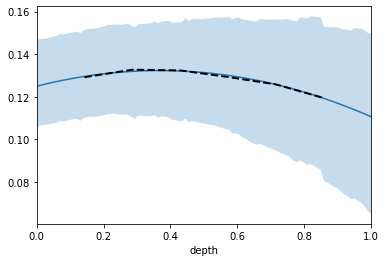

In [562]:
h_b0 = trace2.get_values('h_b0')[:, np.newaxis]
h_b1 = trace2.get_values('h_b1')[:, np.newaxis]
h_b2 = trace2.get_values('h_b2')[:, np.newaxis]

depth = np.linspace(0, 1, 100)[np.newaxis, :]
pred_power = h_b0 + h_b1 * depth + h_b2 * depth**2

lb, ub = pm.stats.hpd(pred_power).T

plt.plot(depth.ravel(), pred_power.mean(0))
plt.fill_between(depth.ravel(), lb, ub, alpha=.25)
tmp.groupby('depth').mean()['power'].plot(c='k', ls='--', lw=2)

In [563]:
pm.waic(trace1, model1), pm.waic(trace2, model2)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for deta

(WAIC_r(WAIC=-324.0535434614247, WAIC_se=9.327799255254304, p_WAIC=13.598951283322496, var_warn=1),
 WAIC_r(WAIC=-399.4341563066902, WAIC_se=6.220301522275269, p_WAIC=15.848314165367727, var_warn=1))

In [564]:
model1.name = 'linear'
model2.name = 'quadratic'
df_comp_WAIC = pm.compare({model1: trace1, model2: trace2})
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
quadratic,-399.43,15.85,0,1,6.22,0,1
linear,-324.05,13.6,75.38,0,9.33,9.18,1


array([[0.04681329, 0.75173652]])

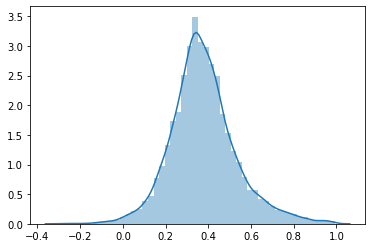

In [565]:
a = h_b2
b = h_b1
x_coord = -b / (2*a)



sns.distplot(x_coord[np.abs(x_coord) < 1])
pm.stats.hpd(x_coord, alpha=0.05)

In [566]:
x_coord.mean()

0.3951678617798558

In [567]:
with model2:
    map = pm.find_MAP()

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 198.91, ||grad|| = 4.0606: 100%|██████████| 102/102 [00:00<00:00, 2333.02it/s]     


In [568]:
-map['h_b1'] / (2*map['h_b2'])

0.3936837251027334

# Decoding

In [569]:
import glob
fns = glob.glob('/data/odc/derivatives/encoding_model/sub-*/ses-*/func/sub-*_desc-V1**.pkl.gz')
df = []

for fn in fns:
    df.append(pd.read_pickle(fn))
    
df = pd.concat(df)

import numpy as np

df.loc[(df['eye'] == 'left') & (df['bayes factor'] > 1), 'correct'] = 1
df.loc[(df['eye'] == 'left') & (df['bayes factor'] < 1), 'correct'] = 0

df.loc[(df['eye'] == 'right') & (df['bayes factor'] > 1), 'correct'] = 0
df.loc[(df['eye'] == 'right') & (df['bayes factor'] < 1), 'correct'] = 1

df['correct'] = df['correct'].astype(float)

df['log(bayes factor)'] = np.log10(df['bayes factor'])
df['q(log(bayes_factor))'] = pd.qcut(df['bayes factor'], 10)

import seaborn as sns

# fac = sns.FacetGrid(df.reset_index().groupby(['subject', 'session', 'n_vertices', 'task', 'roi', 'lambda'], as_index=False).mean(), row='roi', 
#                    aspect=1.5, hue='lambda', col='subject')
# fac.map(sns.lineplot, 'n_vertices', 'correct')
# fac.add_legend()
# fac.set(xscale="log")

/Users/gdehol/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [570]:
tmp = df.groupby(['roi', 'subject', 'session', 'depth'], as_index=False).mean()
tmp['subject_session'] = tmp.apply(lambda row: '{subject}.{session}'.format(**row.to_dict()), 1)
tmp = tmp.set_index('roi')
tmp = tmp[tmp['depth'] != 'all']
tmp['depth'] = tmp['depth'].astype(float)

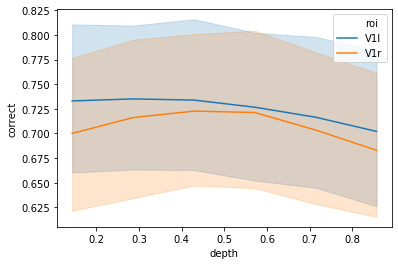

In [571]:
sns.lineplot('depth', 'correct', 'roi', data=tmp.loc[['V1l', 'V1r']].reset_index())

# Left V1

In [572]:
model1, trace1, model2, trace2 = fit_linear_quadratic_model(tmp.loc['V1l'], subj_label='subject_session', x='depth', y='correct')

/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b1_, b0_, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:18<00:00, 153.42draws/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The n

Shape.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b2_, b1_, b0_, sigma_h_b2, h_b2, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [05:25<00:00, 36.91draws/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.


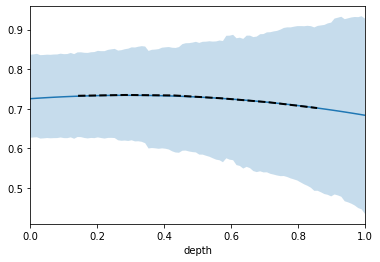

In [573]:
h_b0 = trace2.get_values('h_b0')[:, np.newaxis]
h_b1 = trace2.get_values('h_b1')[:, np.newaxis]
h_b2 = trace2.get_values('h_b2')[:, np.newaxis]

depth = np.linspace(0, 1, 100)[np.newaxis, :]
pred_correct = h_b0 + h_b1 * depth + h_b2 * depth**2

lb, ub = pm.stats.hpd(pred_correct).T

plt.plot(depth.ravel(), pred_correct.mean(0))
plt.fill_between(depth.ravel(), lb, ub, alpha=.25)
tmp.loc['V1l'].groupby('depth').mean()['correct'].plot(c='k', ls='--', lw=2)

In [574]:
model1.name = 'linear'
model2.name = 'quadratic'
df_comp_WAIC = pm.compare({model1: trace1, model2: trace2})
df_comp_WAIC

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for deta

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
quadratic,-321.4,17.93,0,1,10.03,0,1
linear,-257.54,15.6,63.86,0,12.93,14.36,1


[[-1.9397406   3.14944433]] [[-0.19427036  0.72930475]]


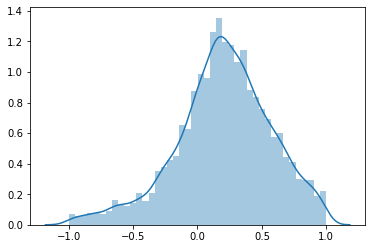

In [575]:
a = h_b2
b = h_b1
x_coord = -b / (2*a)


sns.distplot(x_coord[np.abs(x_coord) < 1])
print(pm.stats.hpd(x_coord, alpha=0.05), pm.stats.hpd(x_coord, alpha=0.33))

In [576]:
print(x_coord.mean())

0.2972582261032718


In [577]:
with model2:
    map = pm.find_MAP()

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 160.48, ||grad|| = 2.9278: 100%|██████████| 528/528 [00:00<00:00, 1339.84it/s]    


In [578]:
-map['h_b1'] / (2*map['h_b2'])

0.2655769617500551

# Right V1

In [579]:
model1, trace1, model2, trace2 = fit_linear_quadratic_model(tmp.loc['V1r'], subj_label='subject_session', x='depth', y='correct')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b1_, b0_, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:10<00:00, 60.67draws/s] 
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Shape.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b2_, b1_, b0_, sigma_h_b2, h_b2, sigma_h_b1, h_b1, sigma_h_b0, h_b0]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:33<00:00, 77.94draws/s] 
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.612000057925979, but should be close to 0.8. Try to increase the number of tuning steps.
There were 281 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.62487457536392, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 817 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4620930769377686, but should be close to 0.8. Try to increase the number of tuning steps.
The

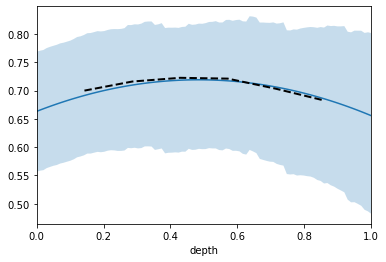

In [580]:
h_b0 = trace2.get_values('h_b0')[:, np.newaxis]
h_b1 = trace2.get_values('h_b1')[:, np.newaxis]
h_b2 = trace2.get_values('h_b2')[:, np.newaxis]

depth = np.linspace(0, 1, 100)[np.newaxis, :]
pred_correct = h_b0 + h_b1 * depth + h_b2 * depth**2

lb, ub = pm.stats.hpd(pred_correct).T

plt.plot(depth.ravel(), pred_correct.mean(0))
plt.fill_between(depth.ravel(), lb, ub, alpha=.25)
tmp.loc['V1r'].groupby('depth').mean()['correct'].plot(c='k', ls='--', lw=2)

In [581]:
model1.name = 'linear'
model2.name = 'quadratic'
df_comp_WAIC = pm.compare({model1: trace1, model2: trace2})
df_comp_WAIC

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for deta

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
quadratic,-291.12,18.16,0,1,9.62,0,1
linear,-217.78,15.08,73.33,0,10.5,7.98,1


0.5585143276014027 [[0.24115172 1.07753329]] [[0.30843229 0.57749092]]


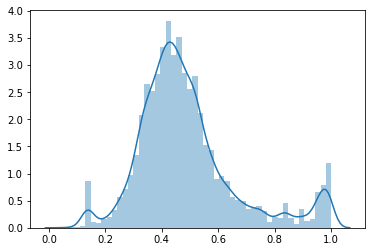

In [582]:
a = h_b2
b = h_b1
x_coord = -b / (2*a)



sns.distplot(x_coord[np.abs(x_coord) < 1.])
print(x_coord.mean(), pm.stats.hpd(x_coord, alpha=0.05), pm.stats.hpd(x_coord, alpha=0.33))

In [583]:
with model2:
    map = pm.find_MAP()

/Users/gdehol/miniconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/gdehol/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 146.95, ||grad|| = 1.0561: 100%|██████████| 797/797 [00:00<00:00, 2264.62it/s]         


In [584]:
-map['h_b1'] / (2*map['h_b2'])

0.45282123822182224